# 2023C2: Plotting SST1 RSoXS Data

## Imports

In [1]:
## Imports
import PyHyperScattering as phs
import pathlib
import sys
import io
import ast
import json
import datetime
import dask.array as da
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm
import dask.array as da
from tiled.client import from_profile, from_uri
import subprocess


print(f'Using PyHyperScattering Version: {phs.__version__}')

/nsls2/users/alevin/repos/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0.2.1+36.g19d2fb8


## Define Paths

In [81]:
def make_para_perp_DAs(datasets, sample_name, edge, intensity_type, pol, qlims, chi_width):
    # select dataarray to plot
    DS = datasets[f'polar_{edge}']
    DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']
    sliced_DA = DA.sel(polarization=pol, q=slice(qlims[0],qlims[1]))

    # calculate ISI dataarrays
    if pol==0:
        para_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        perp_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))
    elif pol==90:
        perp_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        para_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))   
        
    return para_DA, perp_DA

In [108]:
## Define directory paths
userPath = pathlib.Path('/nsls2/users/alevin')
# propPath = pathlib.Path('/nsls2/data/sst/proposals/2022-2/pass-309180')
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-2/pass-311130')
outPath = propPath.joinpath('processed_data')
plotsPath = outPath.joinpath('prsoxs_plots_v3')
jsonPath = outPath.joinpath('local_config')
maskPath = outPath.joinpath('masks')
zarrsPath = outPath.joinpath('zarrs')

## Load DataArrays 

In [169]:
# load dictionary of rsoxs datasets
rsoxs_datasets = {}
# for key in ['cartesian_carbon', 'cartesian_nitrogen', 'cartesian_oxygen', 
#             'polar_carbon', 'polar_nitrogen', 'polar_oxygen']:
for key in ['polar_carbon']:
    key_start = key.split('_')[0]
    key_end = key.split('_')[1]        
    zarrPath = list(zarrsPath.glob(f'{key_start}*{key_end}.zarr'))[0]
    rsoxs_datasets[key] = xr.open_zarr(zarrPath)
    
    # Compute any dask coordiantes
    for coord_name, coord_data in rsoxs_datasets[key].coords.items():
        if isinstance(coord_data.data, da.Array):
            rsoxs_datasets[key].coords[coord_name] = coord_data.compute()
    
    # # Add bare SiN substrate subtracted data variables if necessary
    # if key_start == 'cartesian':
    #     DS = rsoxs_datasets[key]
    #     DS['sin_sub_raw_intensity'] = DS['raw_intensity'] - DS['raw_intensity'].sel(sample_name='BareSiN')
    #     DS['sin_sub_corr_intensity'] = DS['corr_intensity'] - DS['corr_intensity'].sel(sample_name='BareSiN')
    #     rsoxs_datasets[key] = DS

In [170]:
# DS['alo_sub_raw_intensity'] = DS['raw_intensity'] - DS['raw_intensity'].sel(sample_name='BareAlO')
# DS['alo_sub_corr_intensity'] = DS['corr_intensity'] - DS['corr_intensity'].sel(sample_name='BareAlO')

cmap = plt.cm.turbo.copy()
cmap.set_bad(cmap.get_under())

## Intensity Plots

### 1. Detector movies

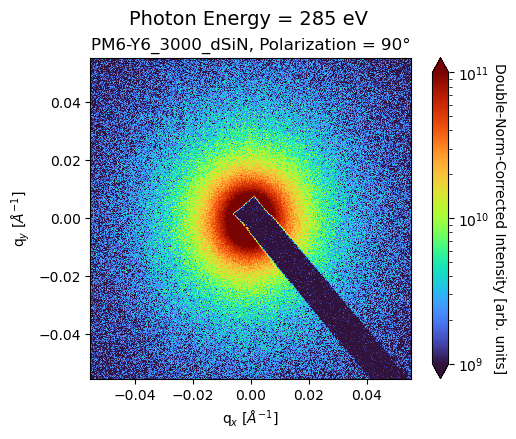

In [6]:
# Select Dataset
edge = 'carbon'
DS = rsoxs_datasets[f'cartesian_{edge}']
bcx = DS['raw_intensity'].beamcenter_x
bcy = DS['raw_intensity'].beamcenter_y

# Select DataArray
sample_name = 'PM6-Y6_3000_dSiN'
intensity_type = 'corr'
DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']

# Select Plotting Parameters
pol = 90
energy = 285
pix_size = 500
pix_x_slice = slice(bcx-(pix_size/2), bcx+(pix_size/2))
pix_y_slice = slice(bcy-(pix_size/2), bcy+(pix_size/2))

# Plot
sliced_DA = DA.sel(polarization=pol, pix_x=pix_x_slice, pix_y=pix_y_slice).sel(energy=energy,method='nearest')
ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='qx', y='qy', cmap=cmap, norm=LogNorm(1e9,1e11))
ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
ax.figure.set_tight_layout(True)
ax.axes.set(aspect='equal', title=f'{sample_name}, Polarization = {pol}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
ax.colorbar.set_label('Double-Norm-Corrected Intensity [arb. units]', rotation=270, labelpad=12)
plt.show()

In [7]:
# Select Dataset
edge = 'carbon'
DS = rsoxs_datasets[f'cartesian_{edge}']
bcx = DS['raw_intensity'].beamcenter_x
bcy = DS['raw_intensity'].beamcenter_y

# Select Plotting Parameters
pol = 90
pix_size = 500
pix_x_slice = slice(bcx-(pix_size/2), bcx+(pix_size/2))
pix_y_slice = slice(bcy-(pix_size/2), bcy+(pix_size/2))
intensity_type = 'corr'

# Select DataArray
# sample_name = 'PM6-Y6_3000_dSiN'
for sample_name in tqdm(DS.sample_name.values[1:]):
    DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']

    output_path = plotsPath.joinpath('detector_movies', f'{sample_name}_{edge}_{intensity_type}_pol{pol}deg.mp4')

    # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
    # It will then output an H.264 encoded MP4 video.
    cmd = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-f', 'image2pipe',
        '-vcodec', 'png',
        '-r', '23',  # Frame rate
        '-i', '-',  # The input comes from a pipe
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',  # Set the quality (lower is better, 17 is often considered visually lossless)
        str(output_path)
    ]

    # Start the subprocess
    proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Loop through the energy dimension and send frames to FFmpeg
    for energy in tqdm(DA.energy.values[:-1], desc=f'Making the {sample_name} movie'):
        # Make & customize plot
        sliced_DA = DA.sel(polarization=pol, pix_x=pix_x_slice, pix_y=pix_y_slice).sel(energy=energy, method='nearest')
        ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='qx', y='qy', cmap=cmap, norm=LogNorm(1e9,1e11))
        ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
        ax.figure.set_tight_layout(True)   
        ax.axes.set(aspect='equal', title=f'{sample_name}, Polarization = {pol}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
        ax.colorbar.set_label('Double-Norm-Corrected Intensity [arb. units]', rotation=270, labelpad=12)

        # Save figure to a PNG buffer
        # ax.figure.savefig(plotsPath.joinpath('detector_movies/frames', f'energy-{round(energy)}_frame-{i:03d}.png'), dpi=120)

        buf = io.BytesIO()
        ax.figure.savefig(buf, format='png')
        buf.seek(0)

        # Write the PNG buffer data to the process
        proc.stdin.write(buf.getvalue())
        plt.close('all')

    # Finish the subprocess
    out, err = proc.communicate()
    if proc.returncode != 0:
        print(f"Error: {err}")


  0%|          | 0/30 [00:00<?, ?it/s]

Making the BareAlO movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y6_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y7_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6-Y6_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6-Y7_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7-Y6_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7-Y7_3000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y6_2000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y7_2000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6_2000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6_2000_dSiN_2 movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7_2000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6_4000_dSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y6_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the Y7_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6-Y6_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6-Y7_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7-Y6_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7-Y7_3000_fSiN movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM6-Y6_3000_dAlO movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the PM7-Y7_3000_dAlO movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the A1_3000_dSiN_01 movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the A1_3000_dSiN_02 movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the A2_3000_dSiN_01 movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the A3_3000_dSiN_01 movie:   0%|          | 0/113 [00:00<?, ?it/s]

Making the A3_3000_dSiN_02 movie:   0%|          | 0/113 [00:00<?, ?it/s]

### 2. ISI Plots

In [171]:
rsoxs_datasets['polar_carbon']

<xarray.Dataset>
Dimensions:                 (chi: 360, sample_name: 31, polarization: 2,
                             energy: 114, q: 500)
Coordinates:
  * chi                     (chi) float64 -179.5 -178.5 -177.5 ... 178.4 179.4
  * energy                  (energy) float64 250.0 255.0 260.0 ... 345.0 350.0
  * polarization            (polarization) int64 0 90
  * q                       (q) float64 0.0001446 0.0003893 ... 0.122 0.1223
  * sample_name             (sample_name) object 'BareSiN' ... 'A3_3000_dSiN_02'
Data variables:
    corr_intensity          (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 1, 5, 360, 500), meta=np.ndarray>
    sin_sub_corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 1, 5, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_carbon

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/utils.py:805: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
/srv/conda/envs/notebook/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


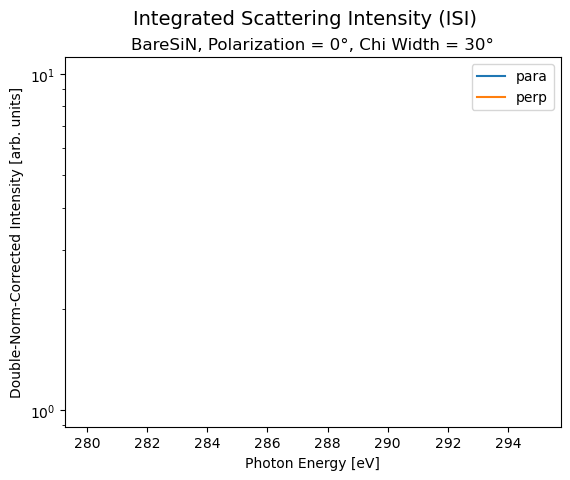

In [177]:
# make selection
sample_name = 'BareSiN'
edge = 'carbon'
intensity_type = 'sin_sub_corr'
pol = 0
qlims = (0.01, 0.08)
chi_width = 30

para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)  

# slice ISI data
para_ISI = para_DA.interpolate_na(dim='q').mean('chi').sum('q')
perp_ISI = perp_DA.interpolate_na(dim='q').mean('chi').sum('q')

# plot
fig, ax = plt.subplots()
para_ISI.sel(energy=slice(280,295)).plot.line(ax=ax, label='para', yscale='log')
perp_ISI.sel(energy=slice(280,295)).plot.line(ax=ax, label='perp', yscale='log')
fig.suptitle('Integrated Scattering Intensity (ISI)', fontsize=14)
ax.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', xlabel='Photon Energy [eV]', ylabel='Double-Norm-Corrected Intensity [arb. units]')
ax.legend()
plt.show()

### 3. 2D Linecut Maps

In [96]:
display(DS.sample_name.values)

array(['BareSiN', 'BareAlO', 'Y6_3000_dSiN', 'Y7_3000_dSiN',
       'PM6_3000_dSiN', 'PM7_3000_dSiN', 'PM6-Y6_3000_dSiN',
       'PM6-Y7_3000_dSiN', 'PM7-Y6_3000_dSiN', 'PM7-Y7_3000_dSiN',
       'PM6_2000_dSiN', 'PM6_2000_dSiN_2', 'PM6_4000_dSiN',
       'Y6_3000_fSiN', 'Y7_3000_fSiN', 'PM6_3000_fSiN', 'PM7_3000_fSiN',
       'PM6-Y6_3000_fSiN', 'PM6-Y7_3000_fSiN', 'PM7-Y6_3000_fSiN',
       'PM7-Y7_3000_fSiN', 'PM6-Y6_3000_dAlO', 'PM7-Y7_3000_dAlO',
       'A1_3000_dSiN_02', 'A2_3000_dSiN_01', 'A3_3000_dSiN_01'],
      dtype='<U16')

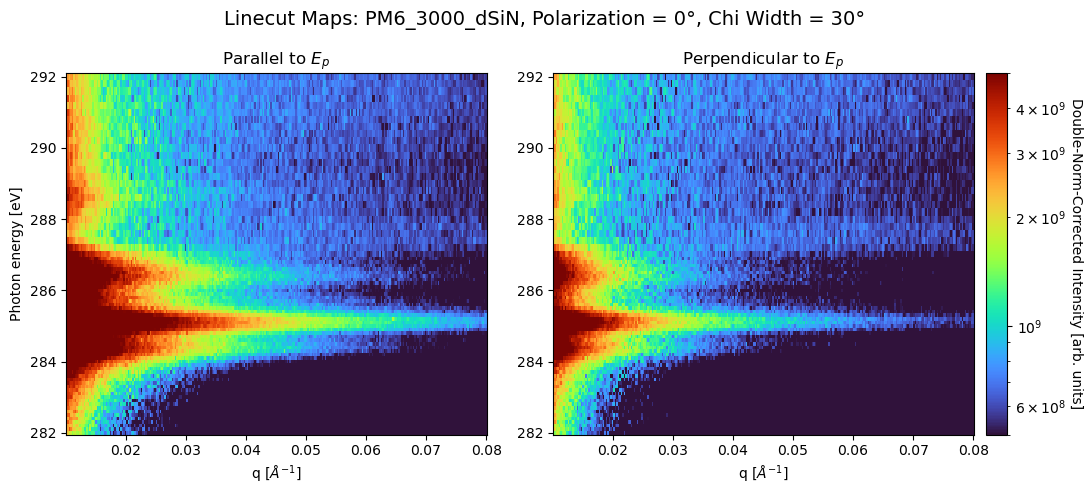

In [180]:
# make selection
sample_name = 'PM6_3000_dSiN'
edge = 'carbon'
intensity_type = 'sin_sub_corr'
pol = 0
qlims = (0.01, 0.08)
chi_width = 30

para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)  

# Plot
fig, axs = plt.subplots(1, 2, figsize=(11,5))
cmin = 5e8
cmax = 5e9

# para_DA.sum('chi').sel(energy=slice(282,290)).plot(ax=axs[0], cmap=cmap, norm=LogNorm(2e10, 1e12), add_colorbar=False)
# perp_DA.sum('chi').sel(energy=slice(282,290)).plot(ax=axs[1], cmap=cmap, norm=LogNorm(2e10, 1e12), add_colorbar=False)
para_DA.mean('chi').sel(energy=slice(282,292)).plot(ax=axs[0], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
perp_DA.mean('chi').sel(energy=slice(282,292)).plot(ax=axs[1], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
# para_DA.mean('chi').sel(energy=slice(525,540)).plot(ax=axs[0], cmap=cmap, norm=LogNorm(1e9, 1e11), add_colorbar=False)
# perp_DA.mean('chi').sel(energy=slice(525,540)).plot(ax=axs[1], cmap=cmap, norm=LogNorm(1e9, 1e11), add_colorbar=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(cmin, cmax)) # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label='Double-Norm-Corrected Intensity [arb. units]', labelpad=12, rotation=270)

fig.suptitle(f'Linecut Maps: {sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', fontsize=14)
fig.set(tight_layout=True)

axs[0].set(title='Parallel to $E_p$', ylabel='Photon energy [eV]', xlabel='q [$Å^{-1}$]')
axs[1].set(title='Perpendicular to $E_p$ ', ylabel=None, xlabel='q [$Å^{-1}$]')

plt.show()

In [ ]:
a = para_EvsQ_avg.hvplot.line(groupby="energy", loglog=True)
a * perp_EvsQ_avg.hvplot.line(groupby="energy")

### 4. Meaned 1D intensity lineplots, selected energies

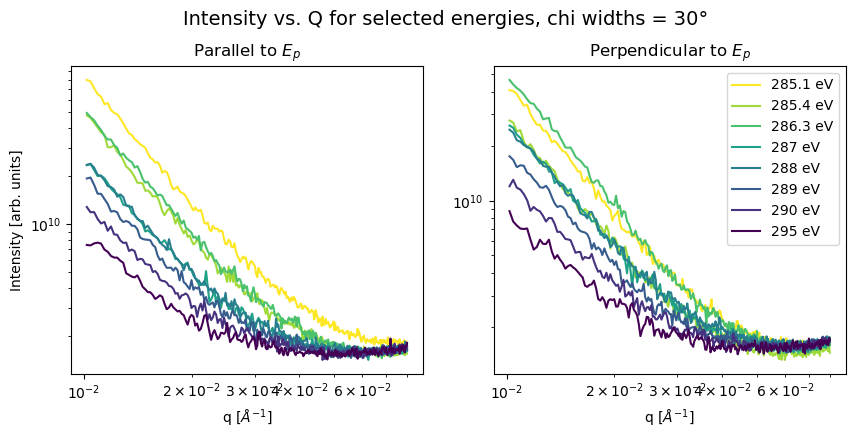

In [99]:
# make selection
sample_name = 'PM6-Y6_3000_dSiN'
edge = 'carbon'
intensity = 'corr'
pol = 0
qlims = (0.01, 0.08)
chi_width = 30

para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)  

# Plot
# energies = [275, 280, 283, 285.1, 286.3, 300, 340]
energies = [285.1, 285.4, 286.3, 287, 288, 289, 290, 295]
fig, (ax_para, ax_perp) = plt.subplots(1,2)
fig.set(size_inches=(10,4))
fig.suptitle(f'Intensity vs. Q for selected energies, chi widths = {chi_width}°', fontsize=14, y = 1.02)
hue = plt.cm.viridis_r(np.linspace(0, 1, len(energies)))
for i, energy in enumerate(energies):
    para_DA.mean('chi').sel(energy=energy, method='nearest').plot.line(
        ax=ax_para, xscale='log', yscale='log', color=hue[i], label=f'{energy} eV')
    perp_DA.mean('chi').sel(energy=energy, method='nearest').plot.line(
        ax=ax_perp, xscale='log', yscale='log', color=hue[i], label=f'{energy} eV')

    
ax_perp.legend()
ax_para.set(title='Parallel to $E_p$', ylabel='Intensity [arb. units]', xlabel='q [$Å^{-1}$]')
ax_perp.set(title='Perpendicular to $E_p$', ylabel=None, xlabel='q [$Å^{-1}$]')

plt.show()

## Anisotropy Ratio Plots

### 1. 2D AR Maps

In [89]:
rsoxs_datasets['polar_samples']

<xarray.Dataset>
Dimensions:         (chi: 360, sample_name: 5, polarization: 2, energy: 114,
                     q: 500)
Coordinates:
  * chi             (chi) float64 -179.5 -178.5 -177.5 ... 177.4 178.4 179.4
  * energy          (energy) float64 250.0 255.0 260.0 ... 340.0 345.0 350.0
  * polarization    (polarization) int64 0 90
  * q               (q) float64 0.0001446 0.0003893 0.0006341 ... 0.122 0.1223
  * sample_name     (sample_name) object 'BareSiN' ... 'PM6-Y7_3000_dSiN'
Data variables:
    corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 1, 5, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_carbon

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


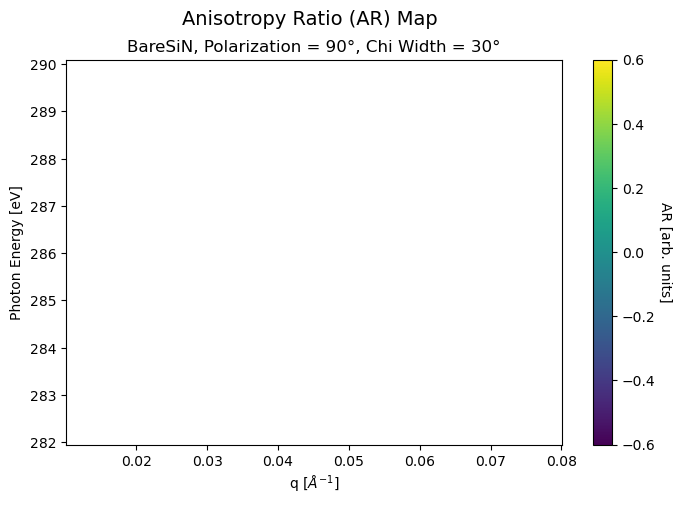

In [183]:
# make selection
sample_name = 'BareSiN'
edge = 'carbon'
intensity_type = 'sin_sub_corr'
pol = 90
qlims = (0.01, 0.08)
chi_width = 30

para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)   

# Select AR data
ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

# Plot
ax = ar_DA.sel(energy=slice(282,290)).plot(figsize=(8,5), norm=plt.Normalize(-0.6, 0.6))
ax.figure.suptitle('Anisotropy Ratio (AR) Map', fontsize=14, x=0.43)
ax.axes.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', ylabel='Photon Energy [eV]', xlabel='q [$Å^{-1}$]')
ax.colorbar.set_label('AR [arb. units]', rotation=270, labelpad=12)
plt.show()

In [ ]:
ARvsQ_avg.hvplot.line(groupby="energy")

### 2. 1D AR Maps

## Loop for saving many plots

In [159]:
plotsPath

PosixPath('/nsls2/data/sst/proposals/2023-2/pass-311130/processed_data/prsoxs_plots_v3')

In [164]:
para_DA.sample_name

<xarray.DataArray 'sample_name' ()>
array('A3_3000_dSiN_02', dtype='<U15')
Coordinates:
    polarization  int64 90
    sample_name   <U15 'A3_3000_dSiN_02'

  0%|          | 0/31 [00:00<?, ?it/s]

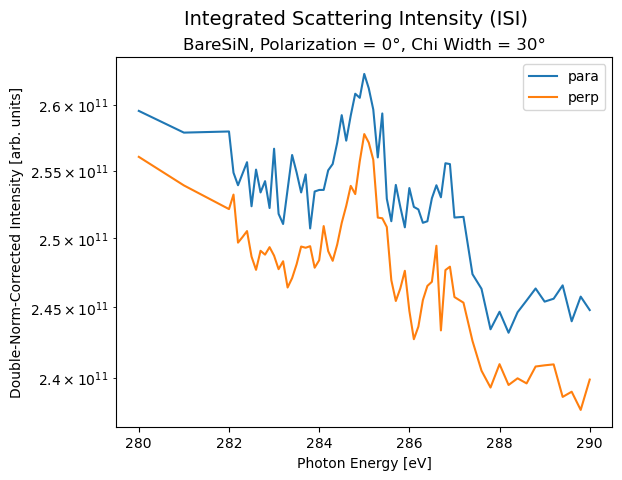

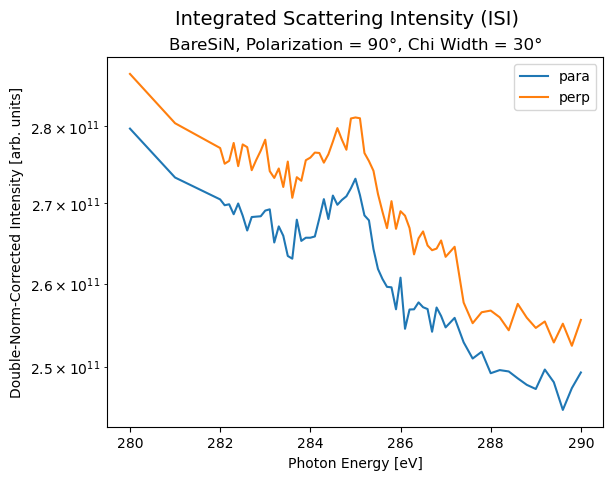

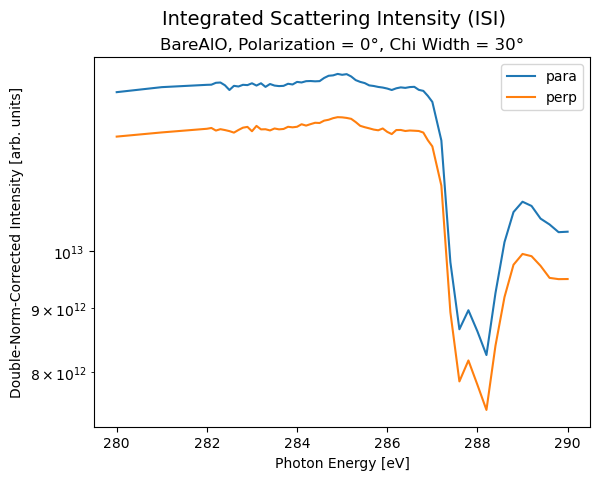

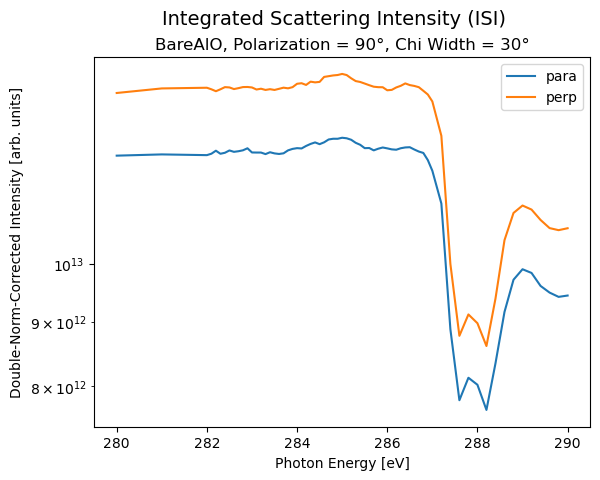

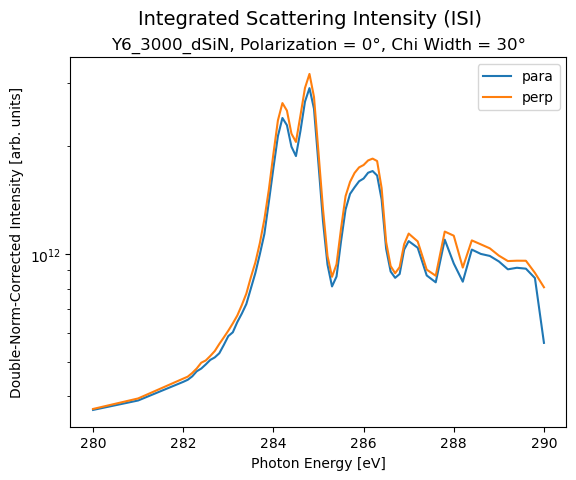

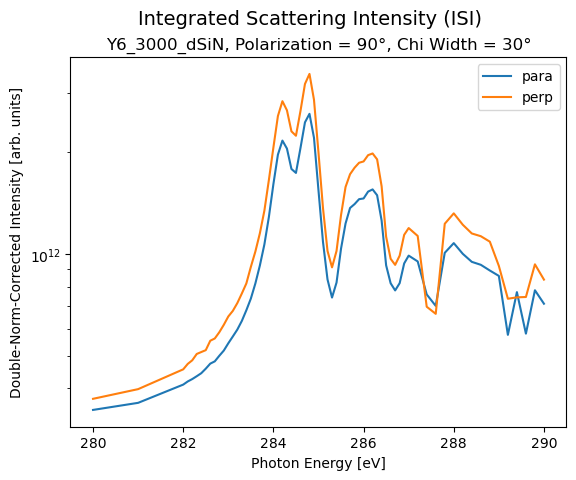

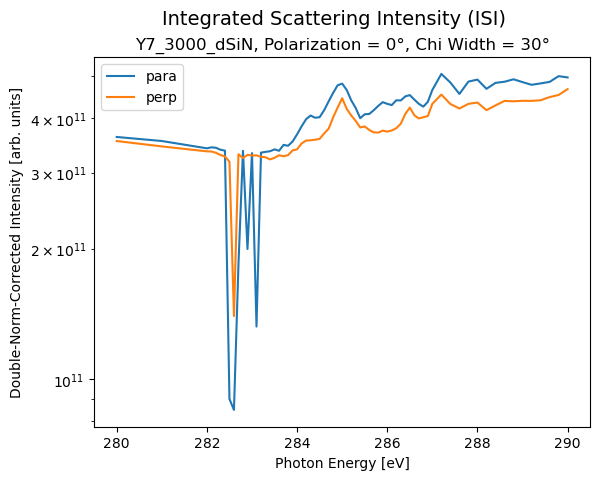

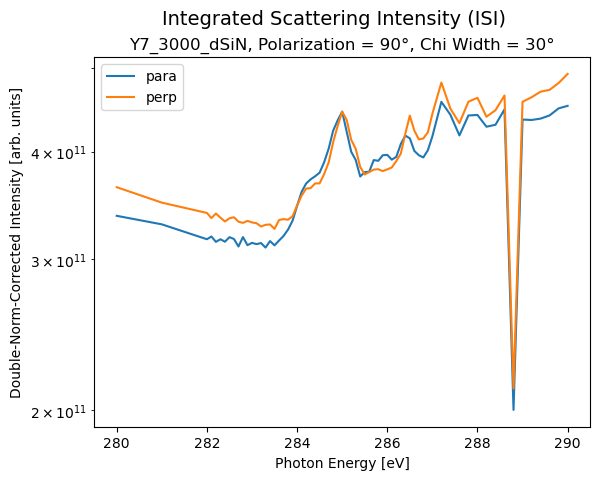

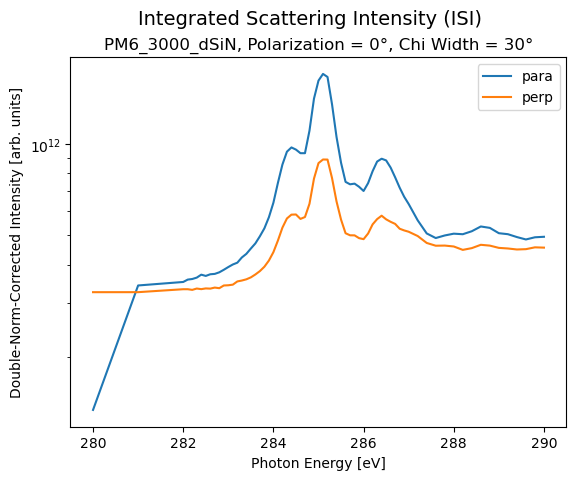

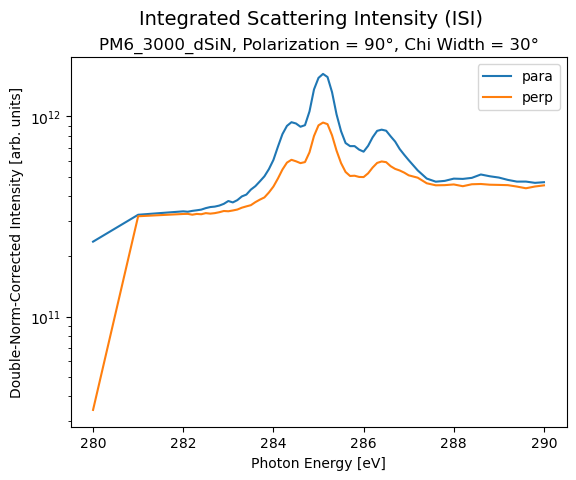

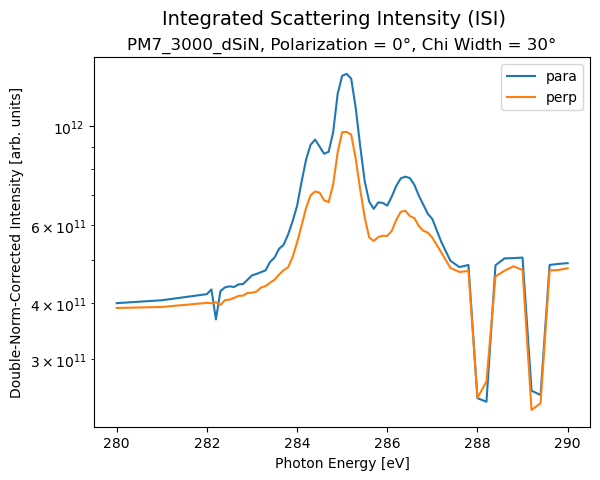

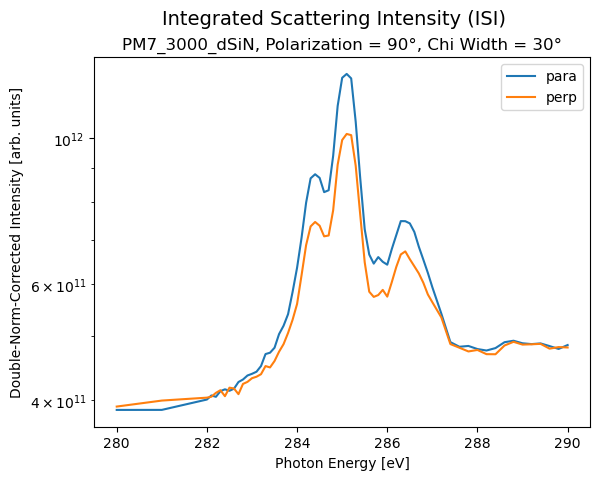

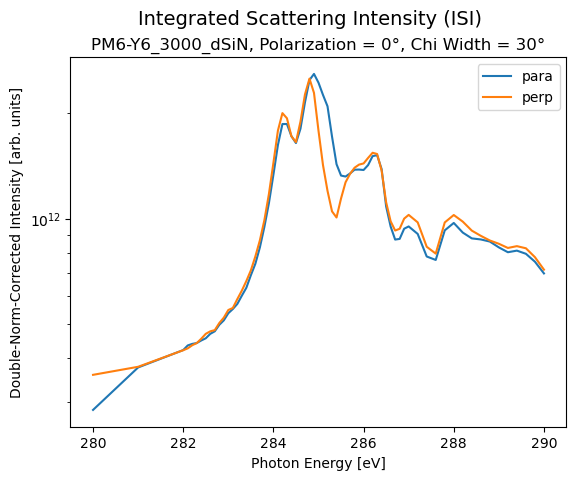

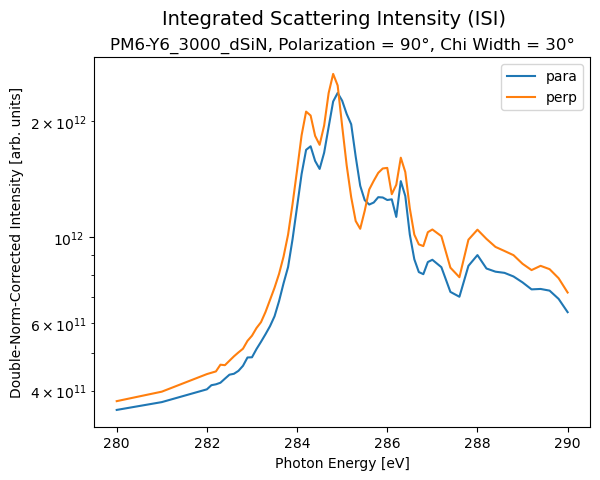

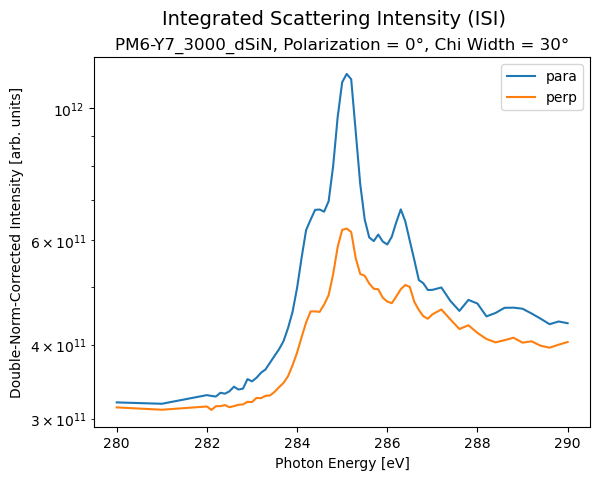

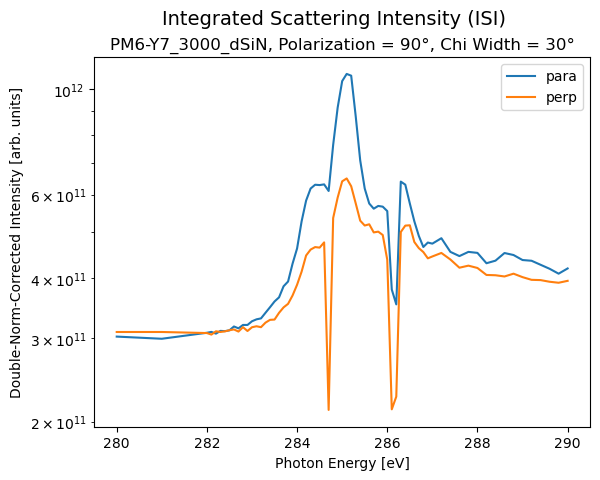

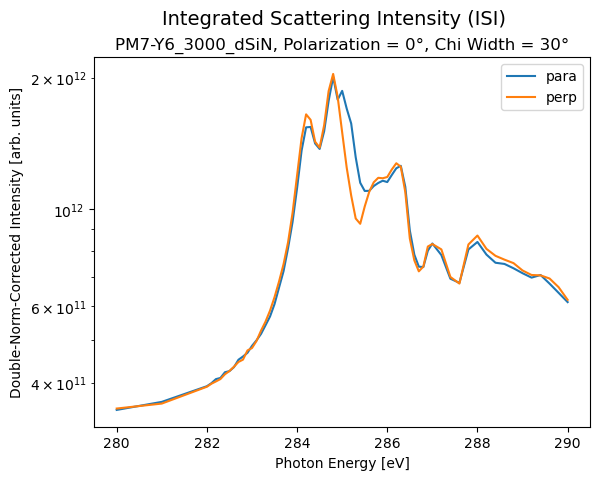

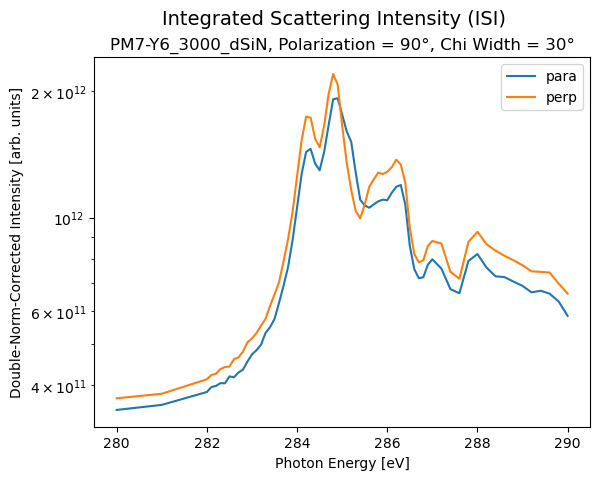

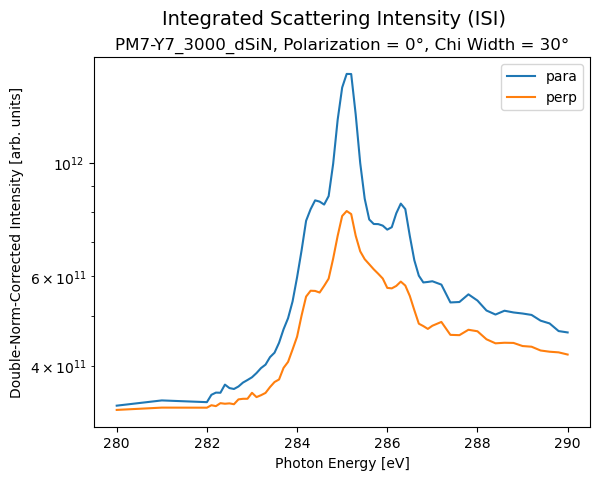

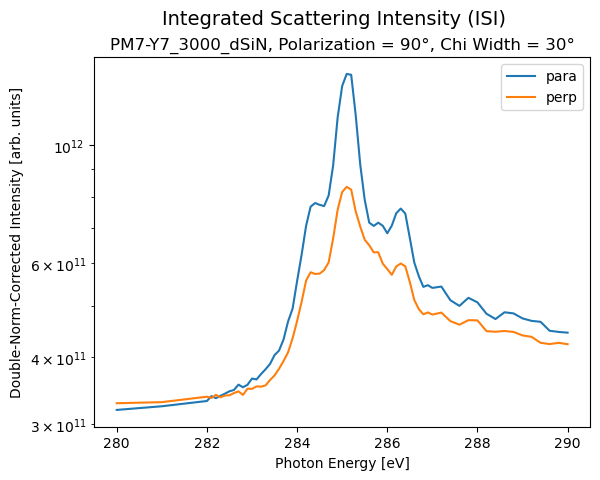

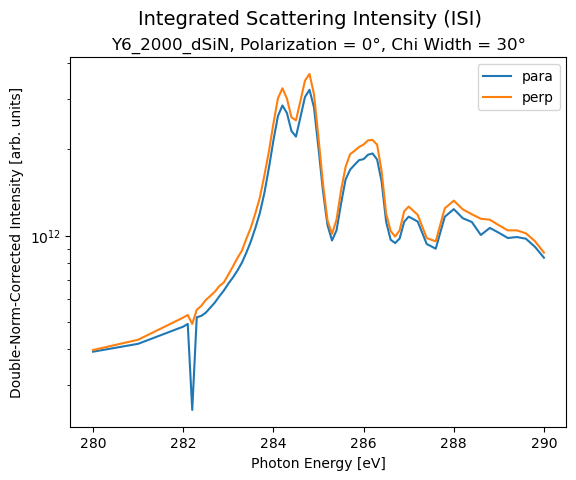

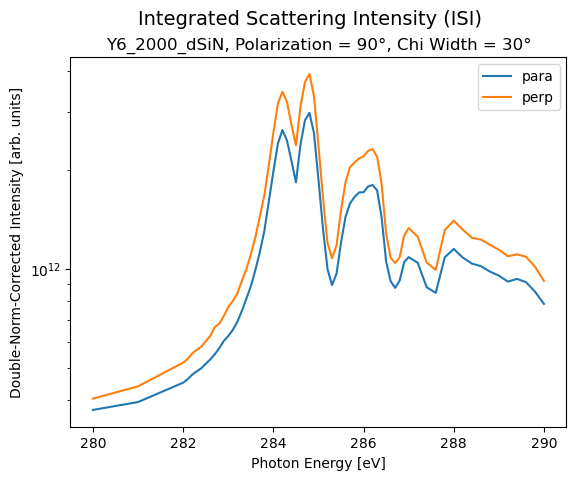

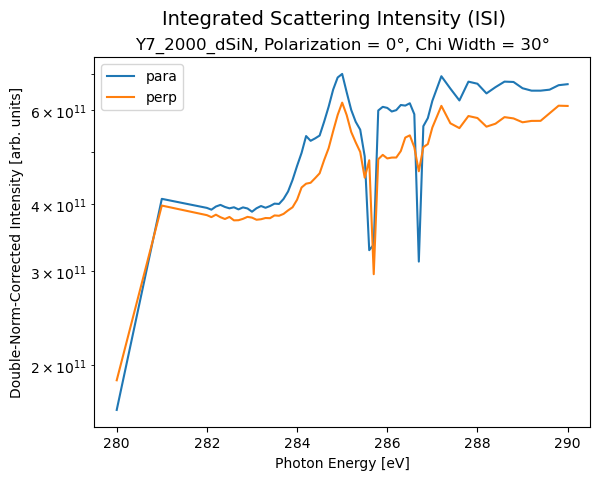

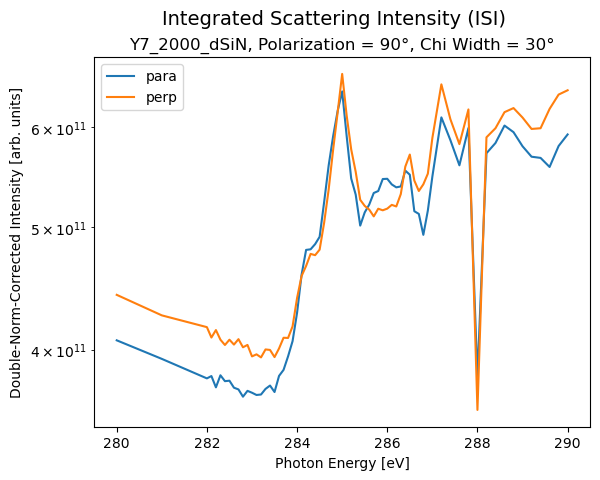

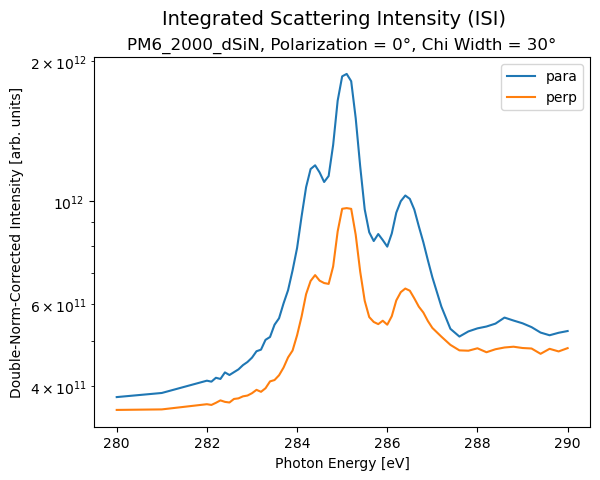

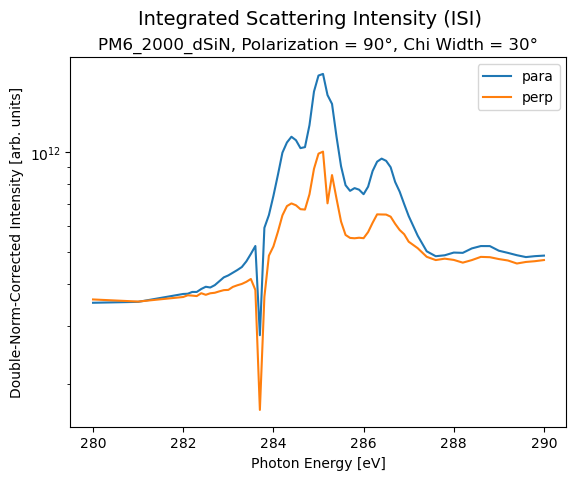

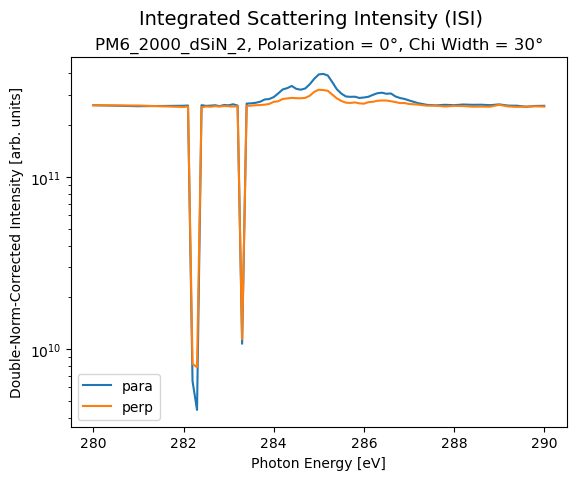

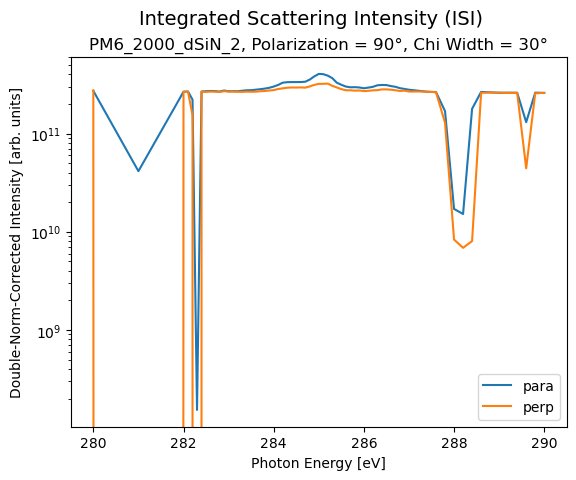

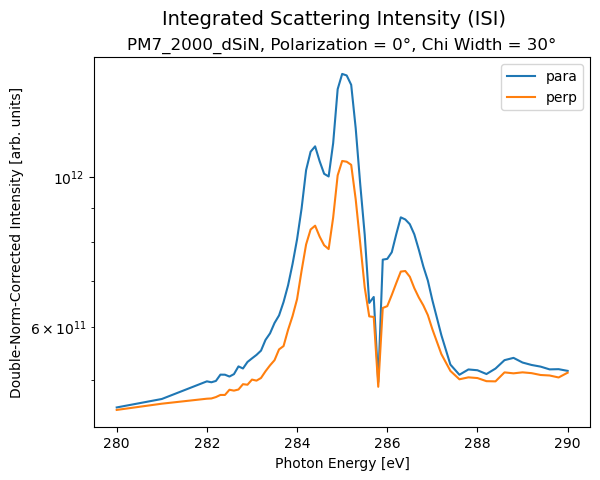

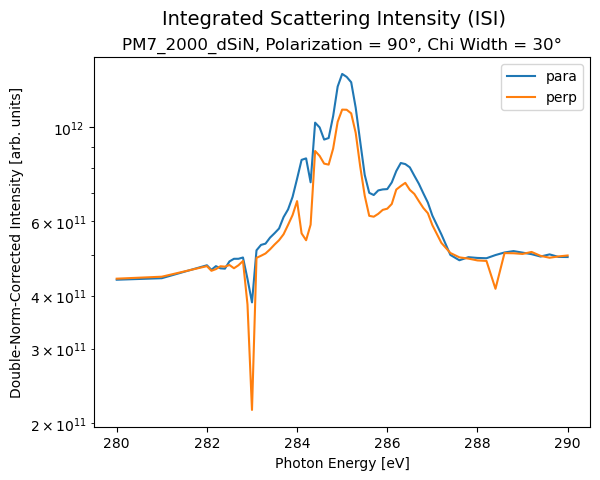

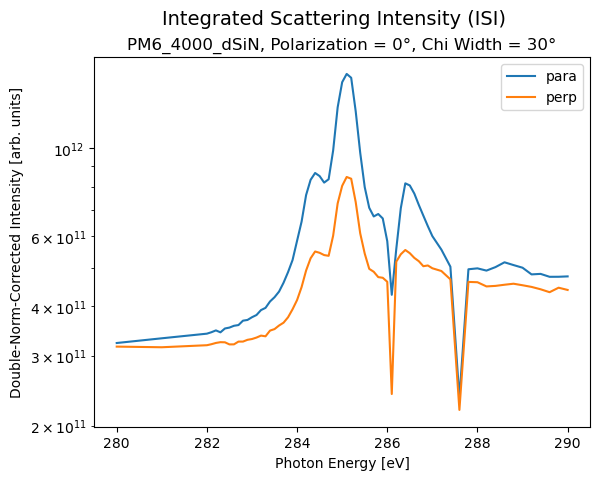

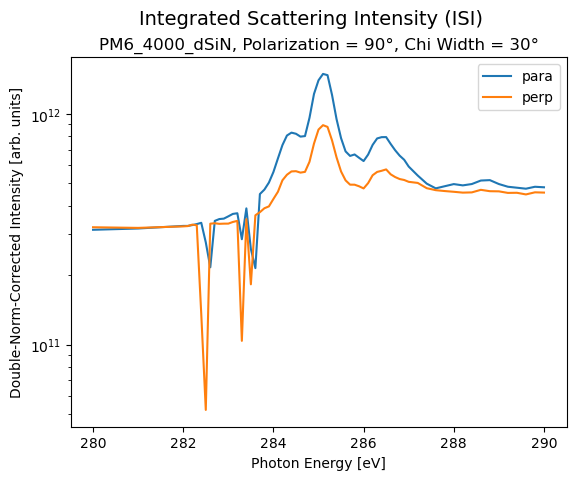

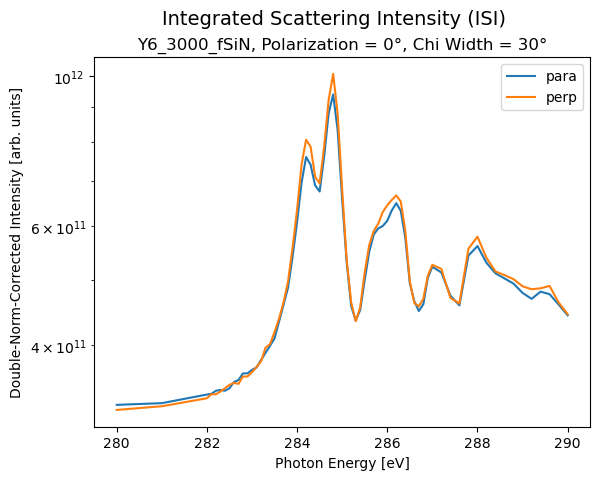

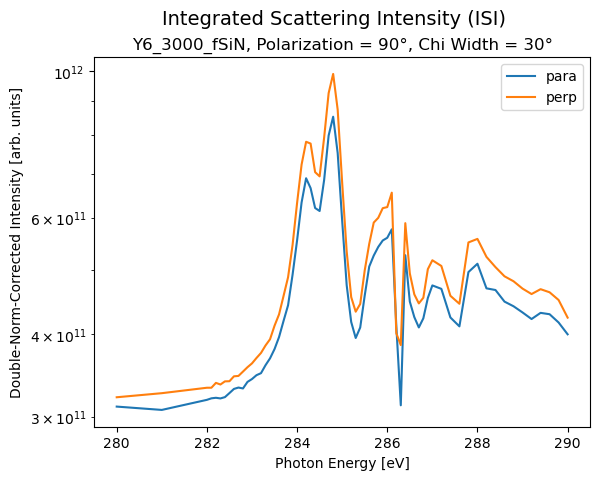

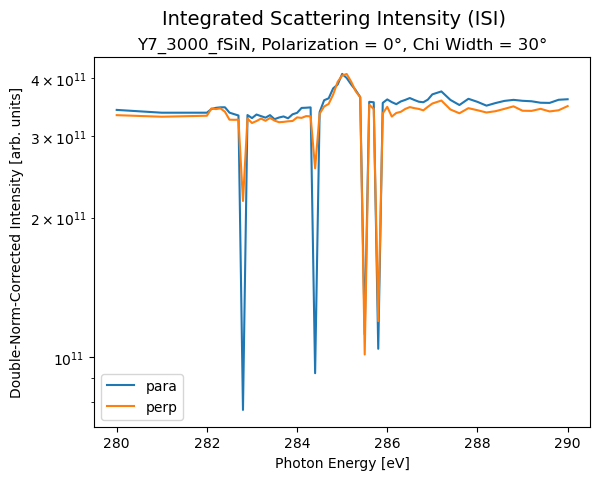

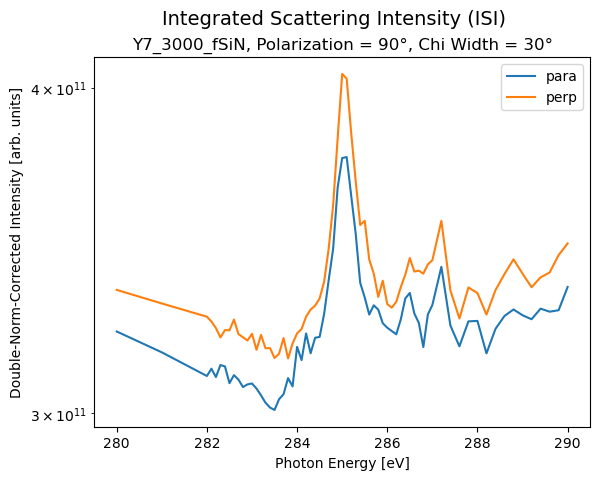

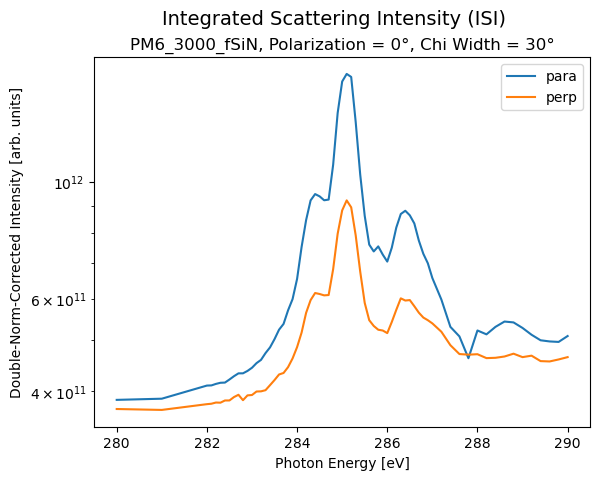

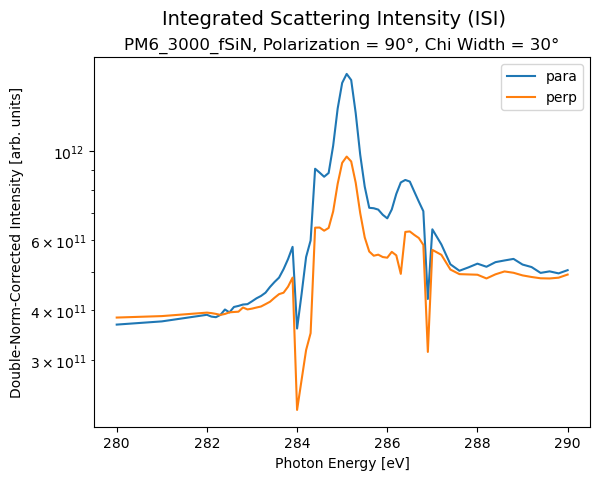

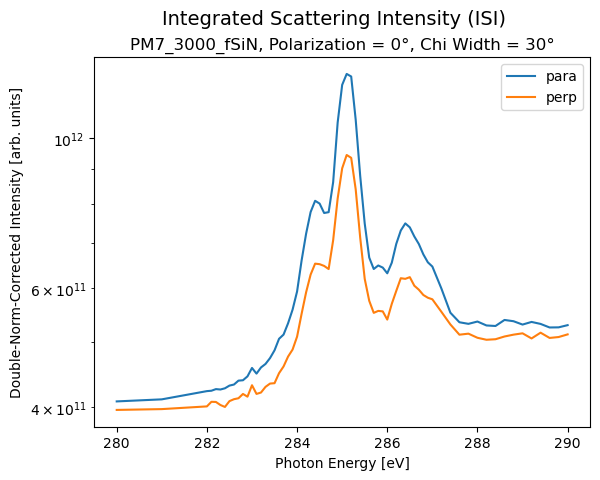

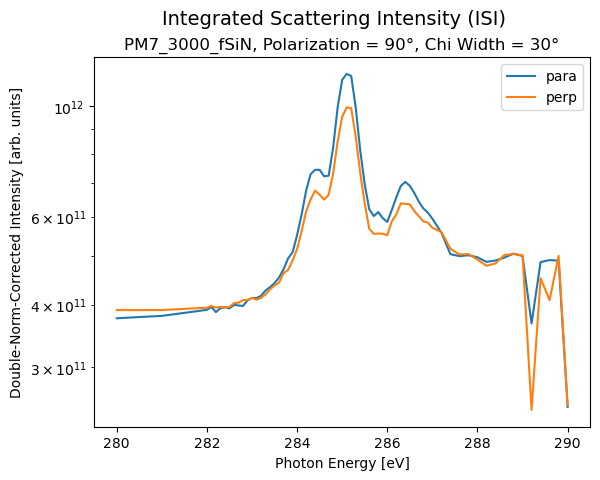

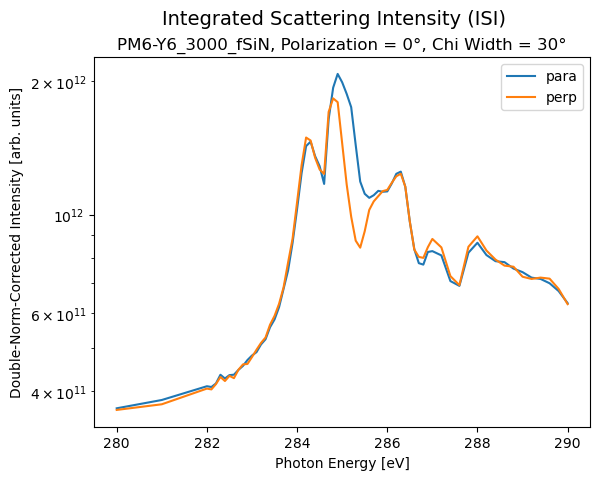

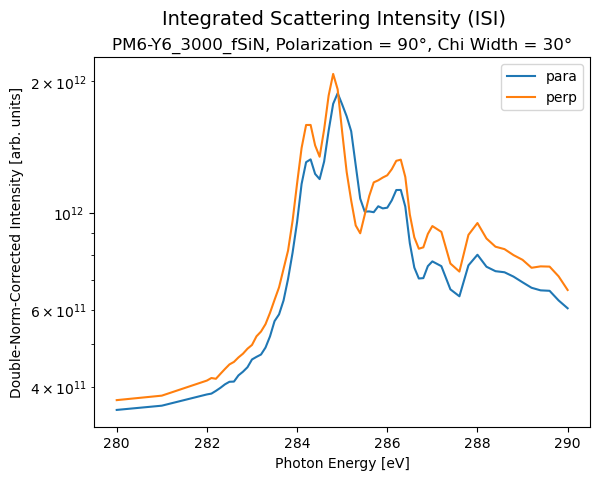

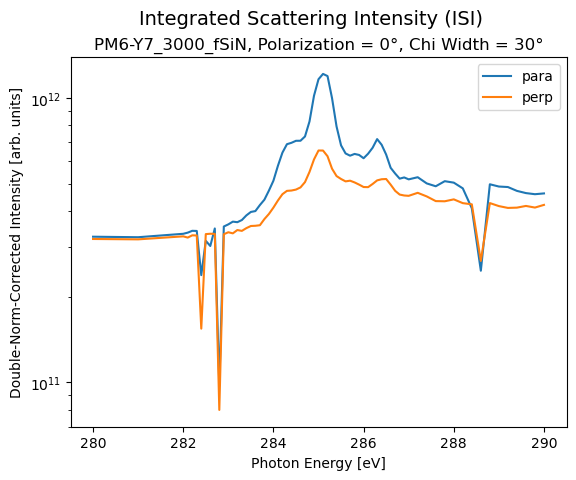

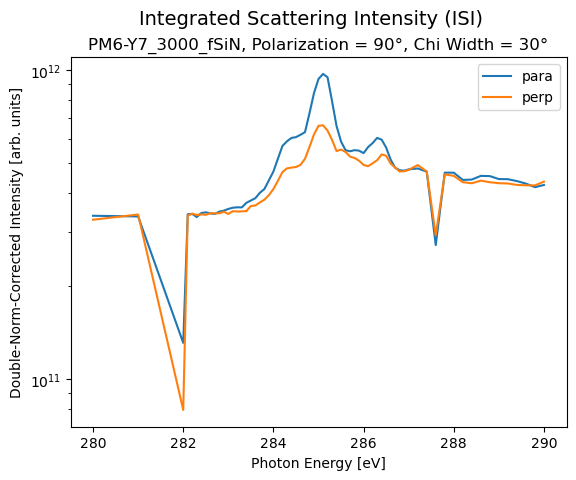

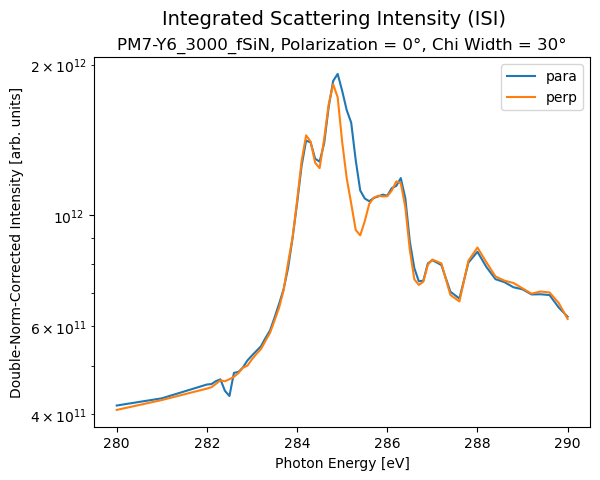

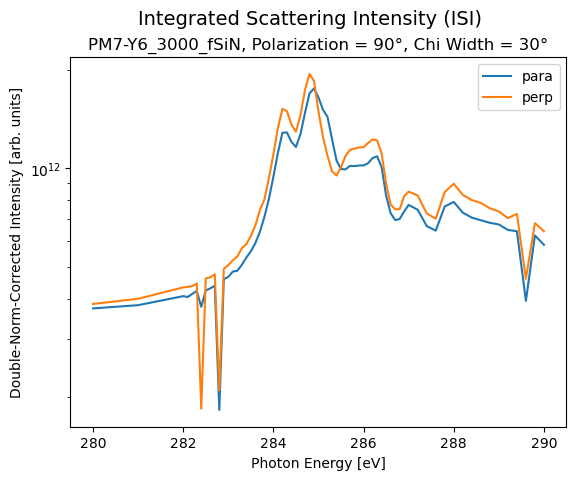

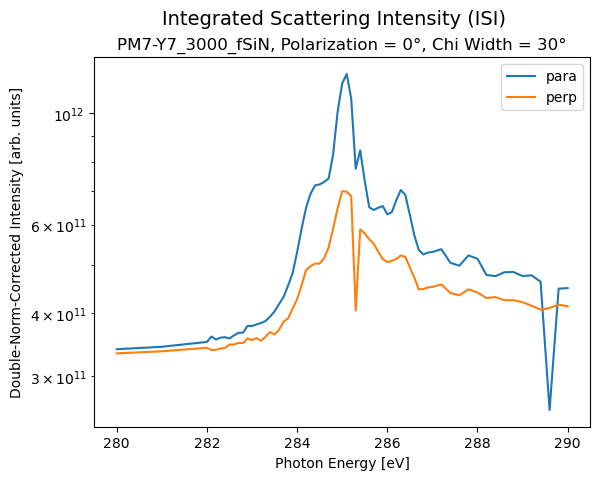

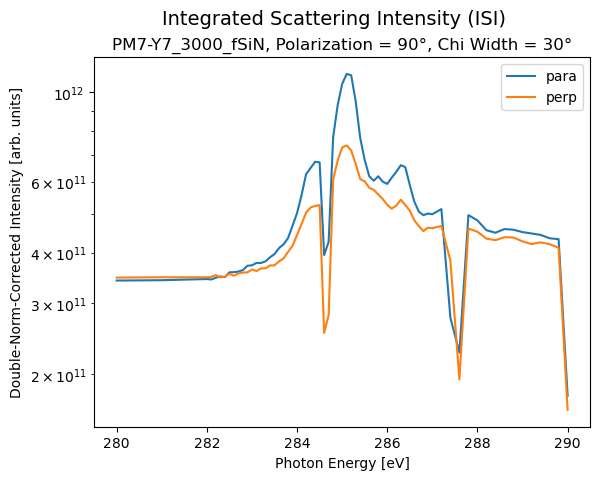

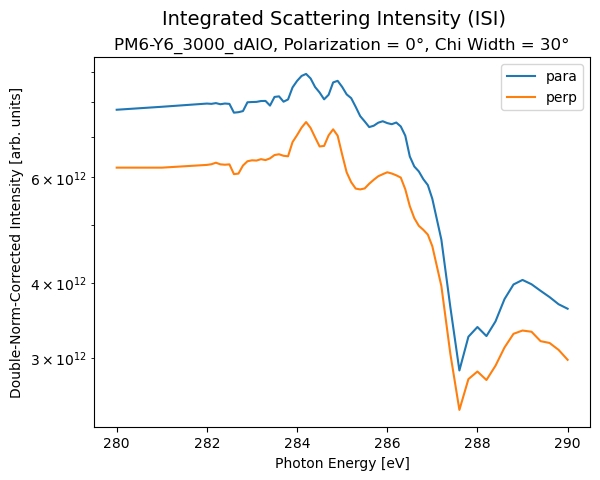

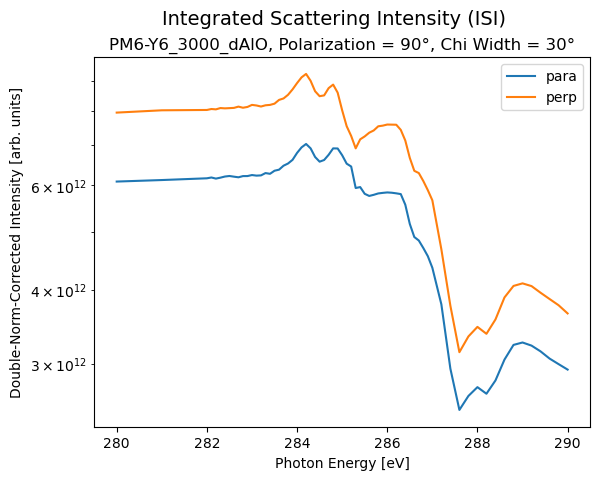

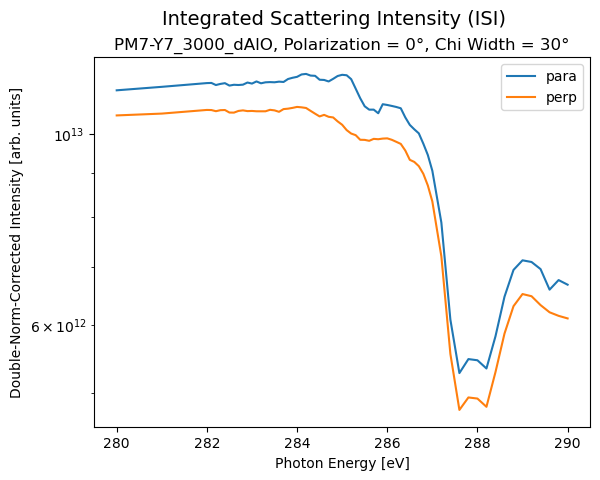

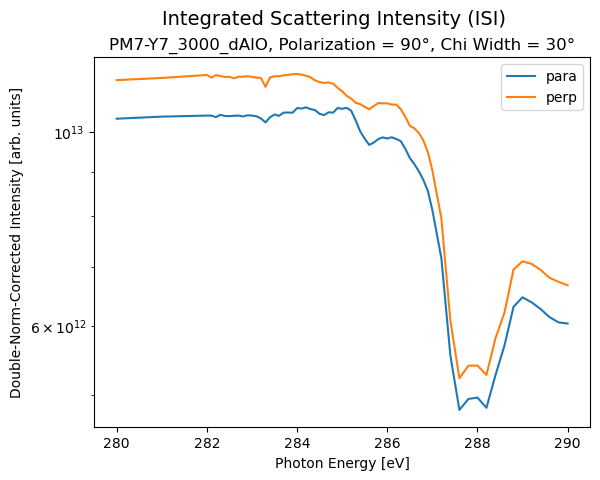

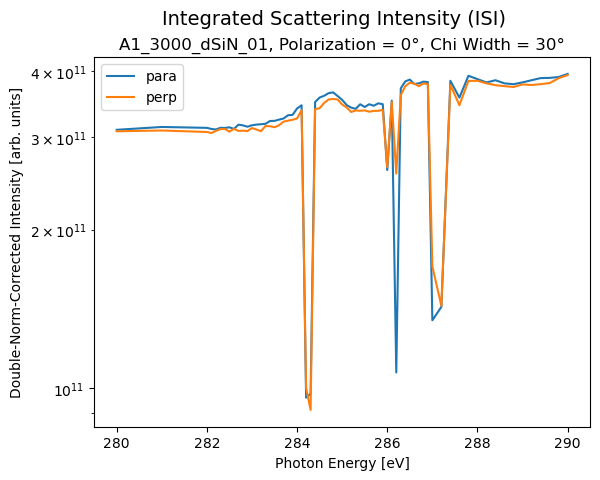

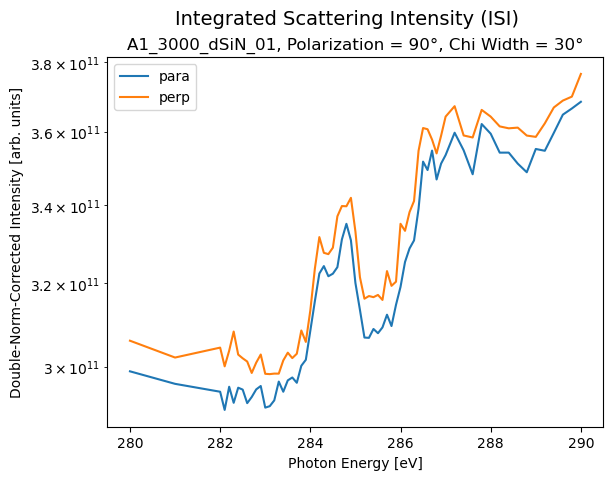

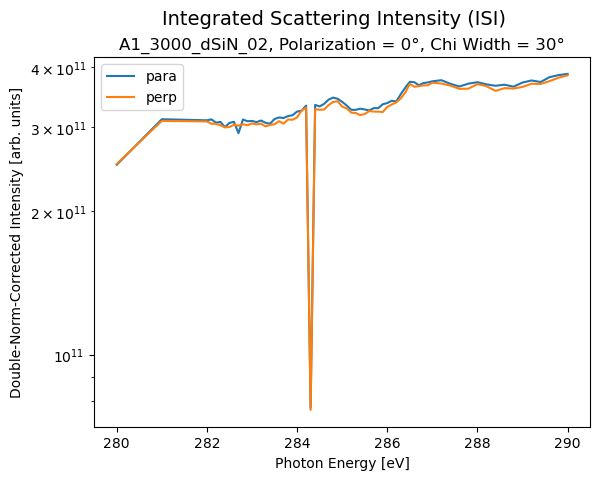

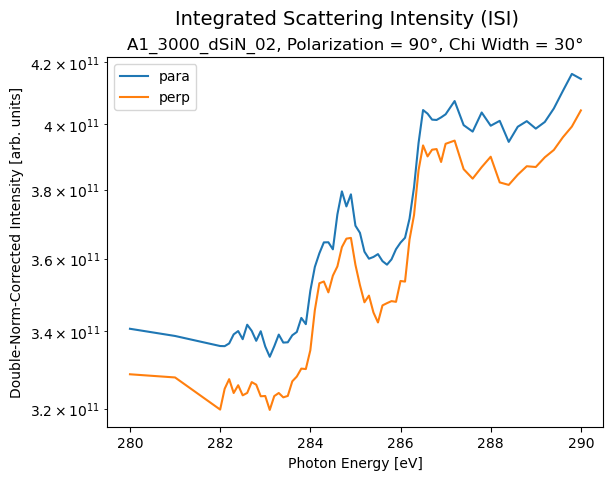

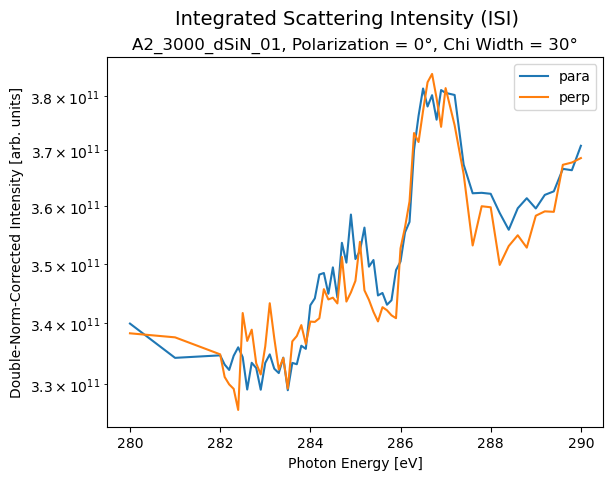

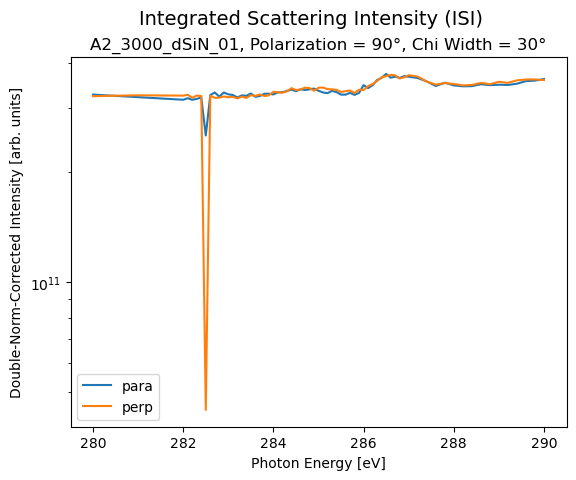

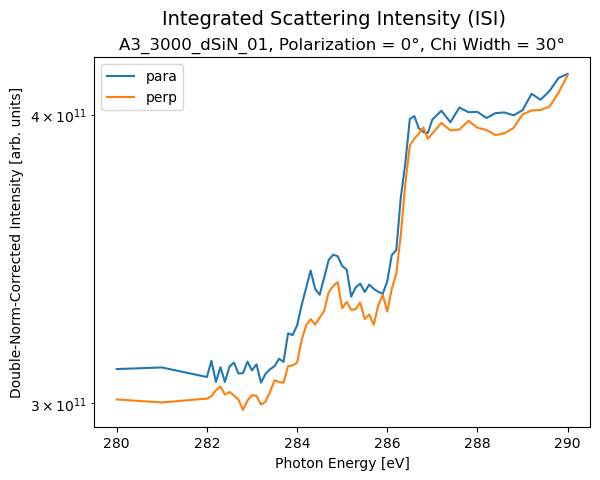

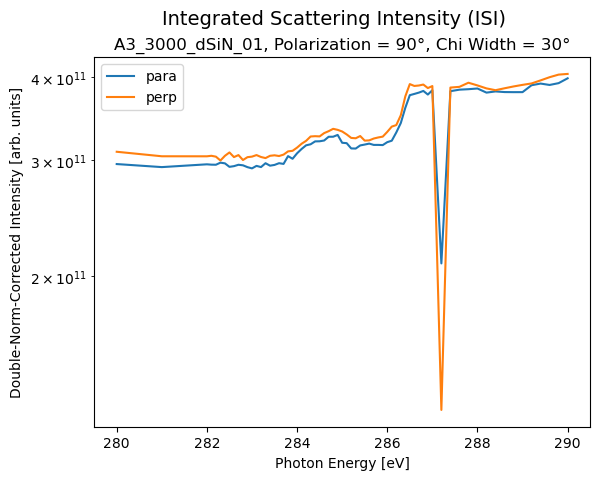

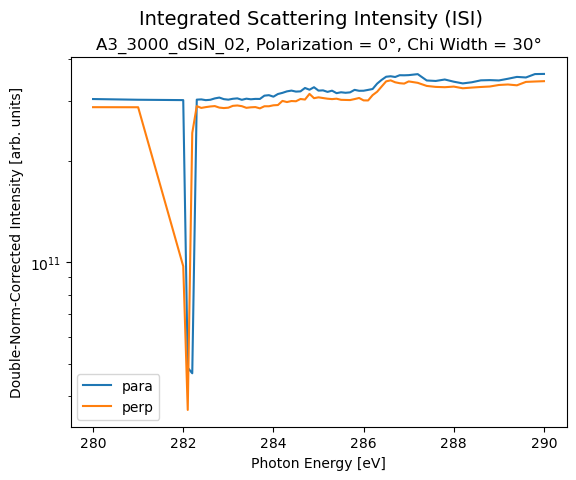

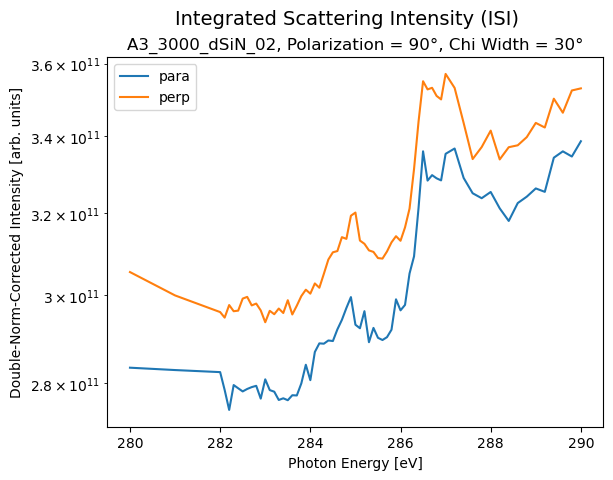

In [186]:
# make selection
edge = 'carbon'
intensity_type = 'corr'
qlims = (0.01, 0.08)
chi_width = 30

for sample_name in tqdm(rsoxs_datasets[f'polar_{edge}'].sample_name.data):
    for pol in [0, 90]:
        ### Select para & perp DataArrays
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)  
        
        ### ISI:
        # Slice ISI data
        para_ISI = para_DA.interpolate_na(dim='q').mean('chi').sum('q')
        perp_ISI = perp_DA.interpolate_na(dim='q').mean('chi').sum('q')

#         if para_DA.sample_name=='BareSiN':
#             bareSiN_para_ISI = para_ISI.copy()
#             bareSiN_perp_ISI = perp_ISI.copy()
            
#         # Subtract SiN
#         para_ISI = para_ISI - bareSiN_para_ISI      
#         perp_ISI = perp_ISI - bareSiN_perp_ISI 
        
        # Plot
        fig, ax = plt.subplots()
        para_ISI.sel(energy=slice(280,290)).plot.line(ax=ax, label='para', yscale='log')
        perp_ISI.sel(energy=slice(280,290)).plot.line(ax=ax, label='perp', yscale='log')
        fig.suptitle('Integrated Scattering Intensity (ISI)', fontsize=14)
        ax.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', xlabel='Photon Energy [eV]', ylabel='Double-Norm-Corrected Intensity [arb. units]')
        ax.legend()
        # fig.savefig(plotsPath.joinpath('isi', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
        plt.show()
        plt.close('all')
        
#         ### Linecut Maps:
#         fig, axs = plt.subplots(1, 2, figsize=(11,5))

#         para_DA.mean('chi').sel(energy=slice(282,290)).plot(ax=axs[0], cmap=cmap, norm=LogNorm(1e9, 1e11), add_colorbar=False)
#         perp_DA.mean('chi').sel(energy=slice(282,290)).plot(ax=axs[1], cmap=cmap, norm=LogNorm(1e9, 1e11), add_colorbar=False)

#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(2e10, 1e12)) # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
#         cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
#         cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
#         cbar.set_label(label='Intensity [arb. units]', labelpad=12)
#         fig.suptitle(f'Linecut Maps: {sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', fontsize=14)
#         fig.set(tight_layout=True)
#         axs[0].set(title='Parallel to $E_p$', ylabel='Photon energy [eV]', xlabel='q [$Å^{-1}$]')
#         axs[1].set(title='Perpendicular to $E_p$ ', ylabel=None, xlabel='q [$Å^{-1}$]')
#         fig.savefig(plotsPath.joinpath('linecut_maps', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
#         plt.close('all')

#         ### AR Maps:
#         # Select AR data
#         ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

#         if para_DA.sample_name=='BareSiN':
#             bareSiN_ar_DA = ar_DA.copy()
            
#         # # Subtract AR from SiN:
#         # ar_DA = ar_DA - bareSiN_ar_DA

#         # Plot
#         ax = ar_DA.sel(energy=slice(282,292)).plot(figsize=(8,5), norm=plt.Normalize(-0.6, 0.6))
#         ax.figure.suptitle('Anisotropy Ratio (AR) Map', fontsize=14, x=0.43)
#         ax.axes.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', ylabel='Photon Energy [eV]', xlabel='q [$Å^{-1}$]')
#         ax.colorbar.set_label('AR [arb. units]', rotation=270, labelpad=12)
#         # ax.figure.savefig(plotsPath.joinpath('ar_maps', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
#         plt.show()
#         plt.close('all')

## Incorporating simulation output
old and incomplete

In [ ]:
import h5py

In [ ]:
whos PosixPath

In [ ]:
simsPath = rootPath.joinpath('imgs_analysis/sim_runs')

In [ ]:
[f.name for f in simPath.iterdir()]

In [ ]:
simPath = simsPath.joinpath('D1.0_a1.0_eps1.0_250pix_375size_0.5m_600steps_1')
h5path = simPath.joinpath('HDF5')
h5list = sorted(h5path.glob('E*h5'))

In [ ]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

#### The scattering pattern is contained within 'K0/projection.' If you simulated multiple incident angles there would be additional 'K#' keys. KIDList contains the vector values for each of the incident angles (propagation direction).

#### Instantiate the PyHyperScattering loader and integrator

In [ ]:
load = phs.load.cyrsoxsLoader(use_chunked_loading=True)
integ = phs.integrate.WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [ ]:
raw = load.loadDirectory(simPath)

In [ ]:
raw

In [ ]:
remeshed = integ.integrateImageStack(raw)

In [ ]:
remeshed

In [ ]:
remeshed.sel(energy=285.1).plot()

In [ ]:
# c = cm.jet(np.linspace(0,1,len(remeshed)))

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=275).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=285).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=295).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.1,0.1),axes.set_ylim(-0.1,0.1)} for axes in ax]
plt.show()

In [ ]:
loaded_rsoxs.build_tiff_stack??